<a href="https://colab.research.google.com/github/Ahmedsayed31/Graduation_project/blob/main/kidney_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Get the data from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedsayed1832","key":"713e5f12f6f65b25174683f0acc517d3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
100% 1.52G/1.52G [01:25<00:00, 22.4MB/s]
100% 1.52G/1.52G [01:25<00:00, 19.0MB/s]


In [ ]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [ ]:
df = pd.read_csv('/content/kidneyData.csv')
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [ ]:
df['Class'].value_counts()

,count
Class,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


## Load the Data

In [ ]:
# main_dir='/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

In [ ]:
import shutil

original_dataset_dir ='/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
base_dir = '/content/drive/MyDrive/Kidney_data'


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


train_split = 0.7
validation_split = 0.15
test_split = 0.15

for label in os.listdir(original_dataset_dir):
    label_dir = os.path.join(original_dataset_dir, label)
    images = os.listdir(label_dir)
    np.random.shuffle(images)

# Count the number of images for each group
    train_index = int(len(images) * train_split)
    validation_index = int(len(images) * (train_split + validation_split))

    train_images = images[:train_index]
    validation_images = images[train_index:validation_index]
    test_images = images[validation_index:]

# Create folders for label in train, validation, and test
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy images for each group
    for image in train_images:
        shutil.copy(os.path.join(label_dir, image), os.path.join(train_dir, label))
    for image in validation_images:
        shutil.copy(os.path.join(label_dir, image), os.path.join(validation_dir, label))
    for image in test_images:
        shutil.copy(os.path.join(label_dir, image), os.path.join(test_dir, label))


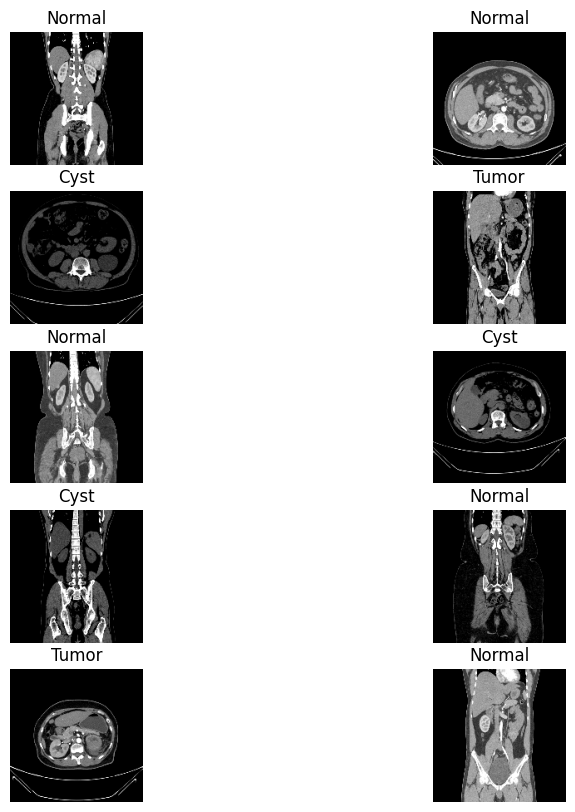

In [ ]:
# # display some sample data
# plt.figure(figsize=(10,10))
# for i in range(10):
#   l = random.randint(0,len(images))
#   plt.subplot(5,2,i+1)
#   plt.imshow(images[l])
#   plt.title(Classes[labels[l]])
#   plt.axis('off')

### Convert images to Vectors for use with SVM

In [ ]:
import os
import cv2
import numpy as np


train_dir='/content/drive/MyDrive/Kidney_data/train'
validation_dir='/content/drive/MyDrive/Kidney_data/validation'
test_dir='/content/drive/MyDrive/Kidney_data/test'

def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (85, 85))
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_folder(train_dir)
# X_val, y_val = load_images_from_folder(validation_dir)
X_test, y_test = load_images_from_folder(test_dir)


In [ ]:
X_train.shape

(8710, 200, 200, 3)

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create and train the SVM model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

svm_model = SVC(kernel="rbf")
svm_model.fit(X_train_flat, y_train)


SVC()

In [ ]:
# Predict on test set
y_pred = svm_model.predict(X_test_flat)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2%}")

# Classification Report
print(classification_report(y_test, y_pred))

Test Accuracy: 99.95%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       762
           2       1.00      1.00      1.00       557
           3       1.00      1.00      1.00       207

    accuracy                           1.00      1869
   macro avg       1.00      1.00      1.00      1869
weighted avg       1.00      1.00      1.00      1869



## Random forest

In [ ]:
from sklearn.forest import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)


In [ ]:
# predict on testset
y_pred = rf_model.predict(X_test_flat)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2%}")

# Classification Report
print(classification_report(y_test, y_pred))

# Load and prepare the data from drive

In [ ]:
train_dir='/content/drive/MyDrive/Kidney_data/train'
validation_dir='/content/drive/MyDrive/Kidney_data/validation'
test_dir='/content/drive/MyDrive/Kidney_data/test'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    )

val_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 8710 images belonging to 4 classes.
Found 1867 images belonging to 4 classes.
Found 1869 images belonging to 4 classes.


## VGG-16

In [ ]:
# Load VGG16 without the upper layers (fully connected layers)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

#Build the Model
model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Freeze the base model layers to prevent them from being trained
vgg_base.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,104,580 (88.14 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.fit(train_generator,epochs=20,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1923s 7s/step - accuracy: 0.5827 - loss: 1.0748 - val_accuracy: 0.8318 - val_loss: 0.4135
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 234s 757ms/step - accuracy: 0.8150 - loss: 0.5087 - val_accuracy: 0.9164 - val_loss: 0.2573
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 212s 760ms/step - accuracy: 0.8760 - loss: 0.3568 - val_accuracy: 0.9266 - val_loss: 0.1989
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 212s 758ms/step - accuracy: 0.9088 - loss: 0.2717 - val_accuracy: 0.9497 - val_loss: 0.1471
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 262s 755ms/step - accuracy: 0.9275 - loss: 0.2225 - val_accuracy: 0.9545 - val_loss: 0.1290
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 212s 759ms/step - accuracy: 0.9396 - loss: 0.1891 - val_accuracy: 0.9684 - val_loss: 0.1026
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 211s 753ms/step - accuracy: 0.9481 - loss: 0.1604 - val_accuracy: 0.9545 - val_loss: 0.1245
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 210s 754ms/step - accuracy: 0.9542 - l

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 763s 13s/step - accuracy: 0.9991 - loss: 0.0192
Test Accuracy: 99.57%


# Evaluate the model

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Models/kidney_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def predict_images(num_images, test_dir, model):
    categories = os.listdir(test_dir)
    categories.sort()
    img_height, img_width = 256, 256

    # Random selection of images
    samples = random.choices(range(len(categories)), k=num_images)

    images = []
    labels = []
    predicted_labels = []

    for i in samples:
        category = categories[i]
        category_dir = os.path.join(test_dir, category)
        image_files = os.listdir(category_dir)

        random_image = random.sample(image_files, 1)
        for image_file in random_image:
            image_path = os.path.join(category_dir, image_file)
            img = load_img(image_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(category)

    images = np.array(images)

    # predict the samples
    predictions = model.predict(images)
    predicted_labels = [categories[np.argmax(pred)] for pred in predictions]

# Calculate the number of rows and columns to display images dynamically
    rows = (num_images + 4) // 5  # Divide the pictures into 5 pictures in each row
    cols = min(num_images, 5)      # Limit the number of columns to a maximum of 5

    #display the results
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        plt.title(f"Actual: {labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


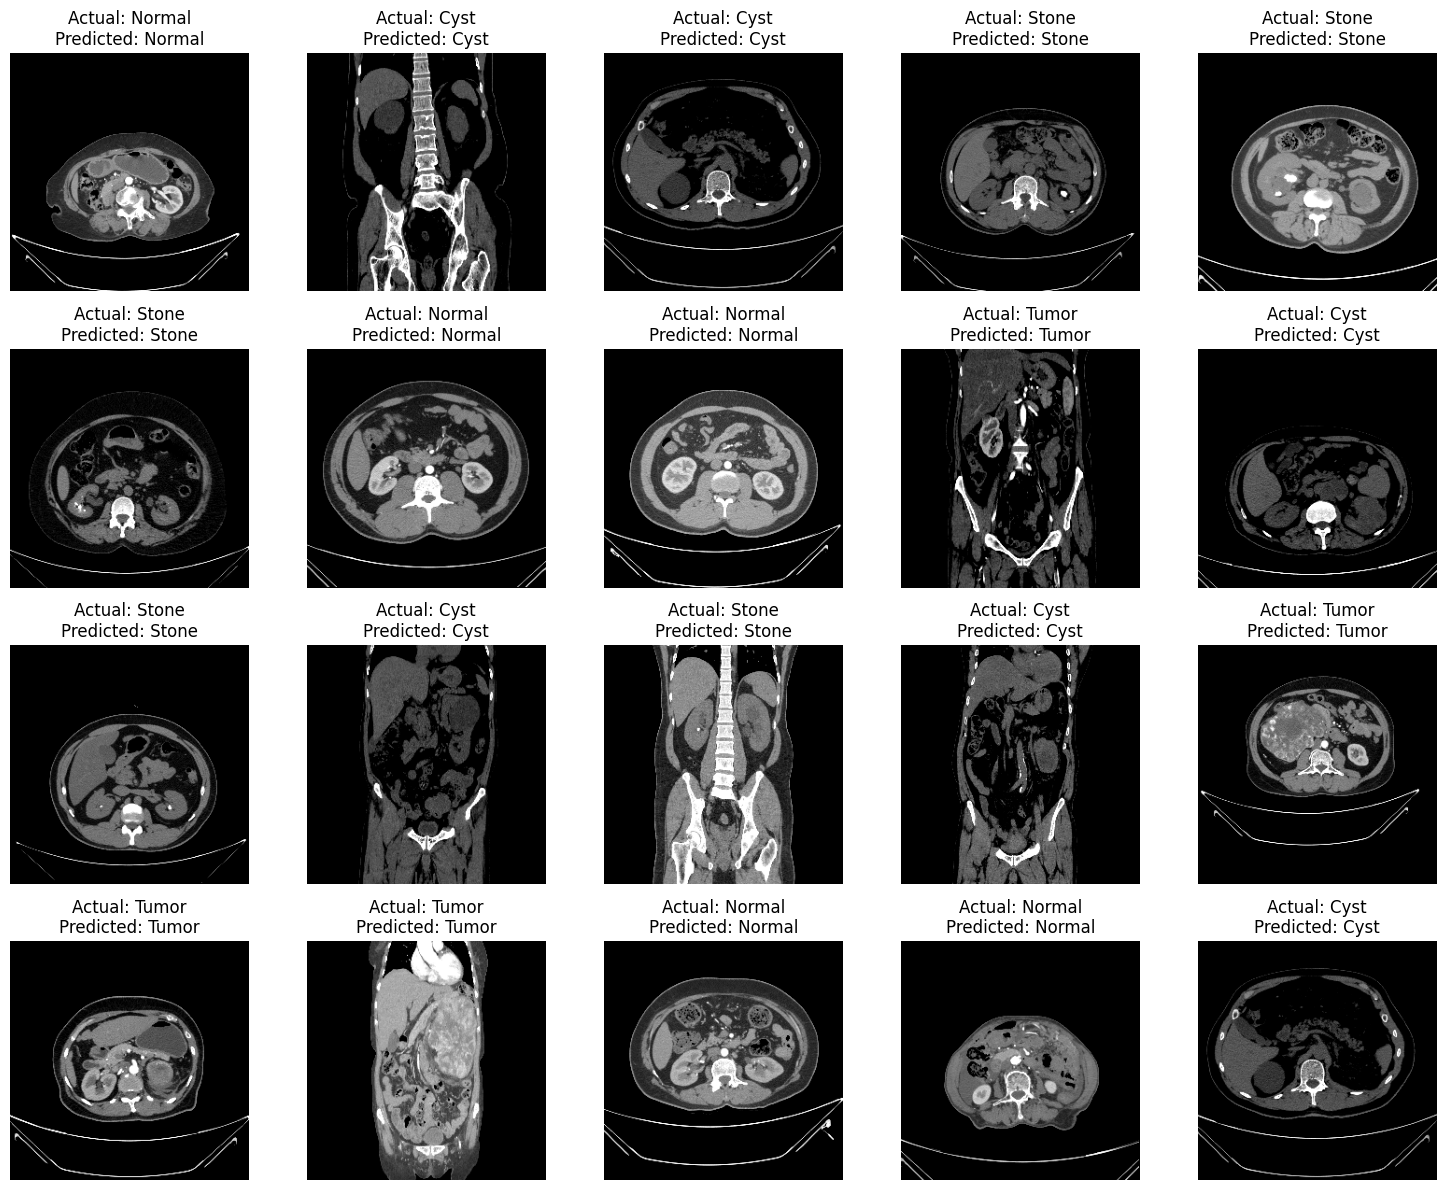

In [ ]:
test_dir='/content/drive/MyDrive/Kidney_data/test'
predict_images(20,test_dir, loaded_model)

In [ ]:
import numpy as np

# Assuming you are using a test generator
y_pred_probs = loaded_model.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes  # Get actual labels from generator


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 488ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       557
      Normal       1.00      1.00      1.00       762
       Stone       1.00      0.98      0.99       207
       Tumor       1.00      0.99      0.99       343

    accuracy                           1.00      1869
   macro avg       1.00      0.99      0.99      1869
weighted avg       1.00      1.00      1.00      1869

Confusion Matrix:
[[557   0   0   0]
 [  0 762   0   0]
 [  4   0 203   0]
 [  1   3   0 339]]


In [ ]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score:", auc_score)

Sensitivity (Recall): [1.         1.         0.98067633 0.98833819]
Specificity: [0.99618902 0.99728997 1.         1.        ]
AUC Score: 0.9997250963181944


In [ ]:
# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:", dice_scores)

# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):", average_dsc)

Dice Similarity Coefficient (DSC) for each class: [0.99553172 0.99803536 0.9902439  0.9941349 ]
Average Dice Similarity Coefficient (DSC): 0.9944864720029334
